In [1]:
import numpy as np
import pandas as pd
import scipy
import scanpy as sc
import scipy.sparse as sp
import anndata as ad
import matplotlib.pyplot as pl
import anndata
import random
import scanpy.plotting
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri

import sklearn as sk
import pandas as pd
import numpy as np
import pathlib as pl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import zero_one_loss
from collections import Counter

import os
import sys
os.chdir("D:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\vignettes")
# os.chdir("C:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\vignettes")
import gc

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

custom_colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
palette = sns.set_palette(sns.color_palette(custom_colors))
FP_CRC_META = os.path.join("crc_meta.csv")
FP_CRC_SEPARATE = os.path.join("crc_separate_taxon.csv")
FP_CRC_WHOLE = os.path.join("crc_whole_taxon.csv")
FP_CRC_MAT = os.path.join("crc_mat.csv")

In [49]:
crc_meta = pd.read_csv(FP_CRC_META)
crc_sepa = pd.read_csv(FP_CRC_SEPARATE)
crc_whole = pd.read_csv(FP_CRC_WHOLE)
crc_data = crc_sepa.iloc[7:, 3:]
crc_data = crc_data.astype(float)

crc_sepa.rename(columns={'Unnamed: 0': 'observations'}, inplace=True)

d:\Anaconda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning:

Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

In [63]:
crc_data

,1,2,3,4,5,6,7,8,9,10,...,926,927,928,929,930,931,932,933,934,935
7,5557520,4501905,3379283,2134734,1875111,1600270,1543442,1537307,1522662,1487988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3426422,91870,4992315,0,2436224,1566408,0,5130,2955614,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3703353,106369,5022513,7228,1626225,2537241,0,342887,776326,1438210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1407572,78931,540874,300730,1104594,491720,0,545275,724756,767280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,6735145,136315,1595369,33915,4128586,3397989,0,505050,2728683,3906722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,1021983,186876,643569,32664,1199899,793182,0,328772,1637341,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7950.0
1653,2306131,22790,21378,327276,781411,397046,0,633642,165012,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1654,1795756,6503,701544,3724477,20806,12635,0,5940563,125387,1484273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655,1615860,191933,328142,2138003,90401,0,0,1069434,3311663,1882126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
crc_meta

,observations,study_name,study_condition
0,SID31004,FengQ_2015,CRC
1,SID31009,FengQ_2015,control
2,SID31021,FengQ_2015,control
3,SID31030,FengQ_2015,adenoma
4,SID31071,FengQ_2015,control
...,...,...,...
1645,CCIS95409808ST.4.0,ZellerG_2014,control
1646,CCIS96387239ST.4.0,ZellerG_2014,adenoma
1647,CCIS98482370ST.3.0,ZellerG_2014,control
1648,CCIS98512455ST.4.0,ZellerG_2014,CRC


In [52]:
crc_sepa

,observations,study_name,study_condition,1,2,3,4,5,6,7,...,926,927,928,929,930,931,932,933,934,935
0,kingdom,NaN,NaN,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,...,k__Eukaryota,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria,k__Bacteria
1,phylum,NaN,NaN,p__Firmicutes,p__Firmicutes,p__Firmicutes,p__Bacteroidetes,p__Actinobacteria,p__Actinobacteria,p__Bacteroidetes,...,p__Ascomycota,p__Firmicutes,p__Firmicutes,p__Proteobacteria,p__Actinobacteria,p__Actinobacteria,p__Firmicutes,p__Firmicutes,p__Proteobacteria,p__Actinobacteria
2,class,NaN,NaN,c__Clostridia,c__Bacilli,c__Clostridia,c__Bacteroidia,c__Coriobacteriia,c__Actinobacteria,c__Bacteroidia,...,c__Saccharomycetes,c__Bacilli,c__Bacilli,c__Epsilonproteobacteria,c__Actinobacteria,c__Actinobacteria,c__Bacilli,c__Bacilli,c__Gammaproteobacteria,c__Actinobacteria
3,order,NaN,NaN,o__Clostridiales,o__Lactobacillales,o__Clostridiales,o__Bacteroidales,o__Coriobacteriales,o__Bifidobacteriales,o__Bacteroidales,...,o__Saccharomycetales,o__Lactobacillales,o__Bacillales,o__Campylobacterales,o__Corynebacteriales,o__Corynebacteriales,o__Lactobacillales,o__Lactobacillales,o__Enterobacterales,o__Actinomycetales
4,family,NaN,NaN,f__Ruminococcaceae,f__Streptococcaceae,f__Lachnospiraceae,f__Bacteroidaceae,f__Coriobacteriaceae,f__Bifidobacteriaceae,f__Bacteroidaceae,...,f__Debaryomycetaceae,f__Leuconostocaceae,f__Staphylococcaceae,f__Campylobacteraceae,f__Corynebacteriaceae,f__Corynebacteriaceae,f__Lactobacillaceae,f__Lactobacillaceae,f__Enterobacteriaceae,f__Actinomycetaceae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,CCIS95409808ST.4.0,ZellerG_2014,control,1021983,186876,643569,32664,1199899,793182,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7950.0
1653,CCIS96387239ST.4.0,ZellerG_2014,adenoma,2306131,22790,21378,327276,781411,397046,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1654,CCIS98482370ST.3.0,ZellerG_2014,control,1795756,6503,701544,3724477,20806,12635,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655,CCIS98512455ST.4.0,ZellerG_2014,CRC,1615860,191933,328142,2138003,90401,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
crc_sepa.columns

Index(['observations', 'study_name', 'study_condition', '1', '2', '3', '4',
       '5', '6', '7',
       ...
       '926', '927', '928', '929', '930', '931', '932', '933', '934', '935'],
      dtype='object', length=938)

In [11]:
crc_whole

,observations,study_name,study_condition,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris,k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_plebeius,...,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_tropicalis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_hellenica,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_coli,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_striatum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudodiphtheriticum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crustorum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_farciminis,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_quasivariicola,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_massiliense
0,SID31004,FengQ_2015,CRC,5557520,4501905,3379283,2134734,1875111,1600270,1543442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SID31009,FengQ_2015,control,3426422,91870,4992315,0,2436224,1566408,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SID31021,FengQ_2015,control,3703353,106369,5022513,7228,1626225,2537241,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SID31030,FengQ_2015,adenoma,1407572,78931,540874,300730,1104594,491720,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SID31071,FengQ_2015,control,6735145,136315,1595369,33915,4128586,3397989,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,CCIS95409808ST.4.0,ZellerG_2014,control,1021983,186876,643569,32664,1199899,793182,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7950.0
1646,CCIS96387239ST.4.0,ZellerG_2014,adenoma,2306131,22790,21378,327276,781411,397046,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1647,CCIS98482370ST.3.0,ZellerG_2014,control,1795756,6503,701544,3724477,20806,12635,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1648,CCIS98512455ST.4.0,ZellerG_2014,CRC,1615860,191933,328142,2138003,90401,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
study_names = np.unique(crc_whole.study_name)

In [26]:
study_names

array(['FengQ_2015', 'GuptaA_2019', 'HanniganGD_2017', 'ThomasAM_2018a',
       'ThomasAM_2018b', 'ThomasAM_2019_c', 'VogtmannE_2016',
       'WirbelJ_2018', 'YachidaS_2019', 'YuJ_2015', 'ZellerG_2014'],
      dtype=object)

In [3]:
# Number of observations per study
Counter(crc_whole.iloc[:,1])

Counter({'FengQ_2015': 154,
         'GuptaA_2019': 60,
         'HanniganGD_2017': 81,
         'ThomasAM_2018a': 80,
         'ThomasAM_2018b': 60,
         'ThomasAM_2019_c': 80,
         'VogtmannE_2016': 110,
         'WirbelJ_2018': 125,
         'YachidaS_2019': 616,
         'YuJ_2015': 128,
         'ZellerG_2014': 156})

In [69]:
# compute not-all-zero species for each study 
valid_species = dict()
for name in study_names:
    X_study = crc_whole[crc_whole['study_name']==name].iloc[:,3:]
    # print(X_study)
    species = X_study.columns[(X_study != 0).any()]
    valid_species[name] = species

In [72]:
print([len(value) for value in valid_species.values()])

[935, 935, 935, 935, 935, 935, 935, 935, 935, 935, 935]


In [71]:
for key in valid_species:
    print(f'{key} has {len(valid_species[key])}')

FengQ_2015 has 935
GuptaA_2019 has 935
HanniganGD_2017 has 935
ThomasAM_2018a has 935
ThomasAM_2018b has 935
ThomasAM_2019_c has 935
VogtmannE_2016 has 935
WirbelJ_2018 has 935
YachidaS_2019 has 935
YuJ_2015 has 935
ZellerG_2014 has 935


In [9]:
crc_data.iloc[100:200, 200:300]

,201,202,203,204,205,206,207,208,209,210,...,291,292,293,294,295,296,297,298,299,300
107,1330.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,1201.0,0.0,0.0,1611.0,0.0,0.0,0.0,0.0,1234.0,66625.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,0.0,0.0,0.0,0.0,9888.0,0.0,0.0,0.0,0.0,314632.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46093.0,0.0
110,5895.0,0.0,0.0,0.0,7055.0,0.0,0.0,0.0,0.0,66283.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9941.0,7189.0,37701.0,0.0
111,0.0,5142.0,2390.0,4597.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254410.0,0.0,85608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,244078.0,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0
203,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,...,0.0,0.0,21482.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0
204,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,307264.0,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0
205,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,683.0,...,0.0,0.0,6748.0,NaN,318741.0,0.0,NaN,0.0,0.0,0.0


In [ ]:
crc_data.applymap(type)

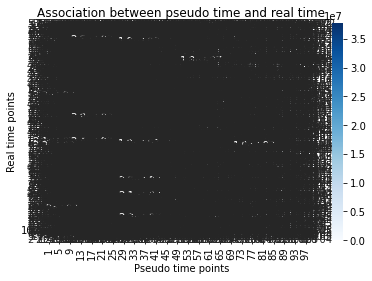

In [6]:
# Create a heatmap
# sns.heatmap(crc_data, annot=True, fmt='d', cmap='Blues')
sns.heatmap(crc_data.iloc[:100,:100], annot=True, cmap='Blues')

# Add labels and title
plt.xlabel('Pseudo time points')
plt.ylabel('Real time points')
plt.title('Association between pseudo time and real time')

# Display the plot
plt.show()

In [16]:
crc_whole

,observations,study_name,study_condition,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris,k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_plebeius,...,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_tropicalis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_hellenica,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_coli,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_striatum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudodiphtheriticum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crustorum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_farciminis,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_quasivariicola,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_massiliense
0,SID31004,FengQ_2015,CRC,5557520,4501905,3379283,2134734,1875111,1600270,1543442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SID31009,FengQ_2015,control,3426422,91870,4992315,0,2436224,1566408,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SID31021,FengQ_2015,control,3703353,106369,5022513,7228,1626225,2537241,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SID31030,FengQ_2015,adenoma,1407572,78931,540874,300730,1104594,491720,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SID31071,FengQ_2015,control,6735145,136315,1595369,33915,4128586,3397989,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,CCIS95409808ST.4.0,ZellerG_2014,control,1021983,186876,643569,32664,1199899,793182,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7950.0
1646,CCIS96387239ST.4.0,ZellerG_2014,adenoma,2306131,22790,21378,327276,781411,397046,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1647,CCIS98482370ST.3.0,ZellerG_2014,control,1795756,6503,701544,3724477,20806,12635,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1648,CCIS98512455ST.4.0,ZellerG_2014,CRC,1615860,191933,328142,2138003,90401,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X = crc_data.values
y = crc_whole['study_name'] == "CRC"

In [20]:
y

0       False
1       False
2       False
3       False
4       False
        ...  
1645    False
1646    False
1647    False
1648    False
1649    False
Name: study_name, Length: 1650, dtype: bool

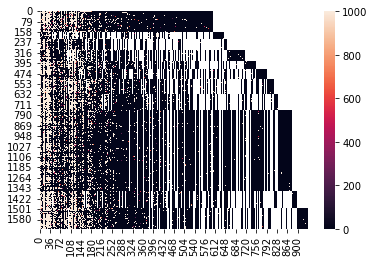

In [22]:
sns.heatmap(X, vmax=1000)

# Display the heatmap
plt.show()

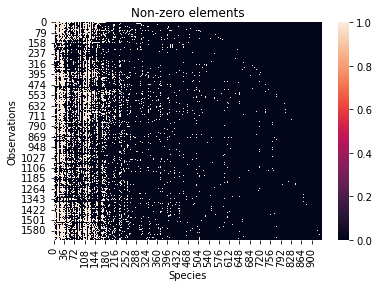

In [37]:
sns.heatmap(X > 0)
plt.xlabel('Species')
plt.ylabel('Observations')
plt.title('Non-zero elements')
plt.show()

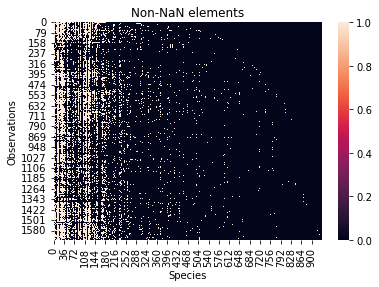

In [36]:
sns.heatmap(np.logical_and(~np.isnan(X), X != 0))
plt.xlabel('Species')
plt.ylabel('Observations')
plt.title('Non-NaN elements')
plt.show()

In [52]:
np.mean(X>0)

0.10142991411440609

In [51]:
1-np.mean(np.isnan(X))

0.6413488899692108

In [39]:
X[np.isnan(X)] = 0.0

In [41]:
X

array([[5.557520e+06, 4.501905e+06, 3.379283e+06, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.426422e+06, 9.187000e+04, 4.992315e+06, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.703353e+06, 1.063690e+05, 5.022513e+06, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.795756e+06, 6.503000e+03, 7.015440e+05, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.615860e+06, 1.919330e+05, 3.281420e+05, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.390451e+06, 4.990000e+03, 1.401648e+06, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

d:\Anaconda\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



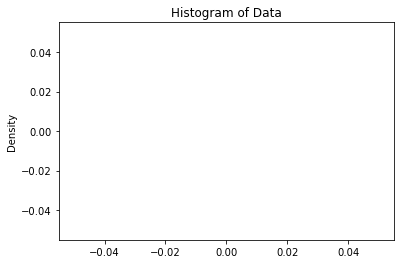

In [53]:
sns.histplot(data=X.reshape(-1), binwidth=0.1, binrange=[0.1, 5], stat="density")
plt.title("Histogram of Data")
# plt.xlabel("X-axis Label")
# plt.ylabel("Y-axis Label")
plt.show()

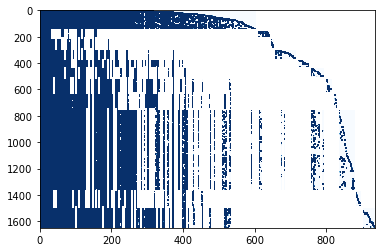

In [54]:
plt.imshow(X, cmap='Blues', aspect='auto', vmin=0, vmax=1)

In [89]:
study_test = [study_names[-1]]
study_train = study_names[:-1]

In [95]:
data_train = crc[crc['study_name'].isin(study_train)]
data_test = crc[crc['study_name'].isin(study_test)]

X_train = data_train.iloc[:, 4:].values
X_test = data_test.iloc[:, 4:].values
y_train = data_train.iloc[:, 2] == "CRC"
y_test = data_test.iloc[:, 2] == "CRC"

In [96]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(275, 754)
(60, 754)
(275,)
(60,)


In [135]:
# Run PCA
p = 100

X_train_sd = StandardScaler().fit_transform(X_train)
X_train_pca = PCA(n_components=p)
X_train_pca.fit(X_train_sd)
X_train = X_train_pca.transform(X_train_sd)

In [141]:
# Logstic
model = LogisticRegression()
model.fit(X_train, y_train)

X_test_sd = StandardScaler().fit_transform(X_test)
X_test = X_train_pca.transform(X_test_sd)
y_pred = model.predict(X_test)

loss = zero_one_loss(y_pred, y_test)

print("0-1 loss of the test set:", loss)

0-1 loss of the test set: 0.4833333333333333


In [127]:
X_test.shape

(60, 100)

In [132]:
X_test_sd.shape

(60, 100)

In [ ]:
# # Load the RDA file
# robjects.r['load'](FP_CRC)

# # Convert the R data frame to a Pandas data frame
# r_dataframe = robjects.r['se']
# pandas_dataframe = pd.DataFrame(dict(zip(r_dataframe.names, list(r_dataframe))))

# # Use the Pandas data frame in Python
# print(pandas_dataframe.head())